In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langgraph.graph import StateGraph, END 
from typing import TypedDict, List
from langgraph.checkpoint.sqlite import SqliteSaver 
from langchain_core.messages import SystemMessage, HumanMessage

from prompts import *

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
class AgentState(TypedDict):
    query: str 
    definition: str 
    decomposed_steps: List[str]
    solved_steps: List[str]
    completed_step: int

In [4]:
from langchain_core.pydantic_v1 import BaseModel
from langchain.output_parsers import PydanticOutputParser

class Steps(BaseModel):
    steps: List[str]

In [5]:
def problem_definer_node(state: AgentState):
    messages = [
        SystemMessage(content=PROBLEM_DEFINER_PROMPT),
        HumanMessage(content=state['query'])
    ]
    response = llm.invoke(messages)
    return {"definition": response.content}

In [6]:
def problem_decomposer_node(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=Steps)
    
    chain = llm | parser
    system_message = f"{PROBLEM_DECOMPOSER_PROMPT}\n\nFormat Instructions: {parser.get_format_instructions()}"
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=state['definition'])
    ]
    
    steps = chain.invoke(messages)
    return {"decomposed_steps": steps.steps}

In [7]:
def step_generator(state: AgentState):
    solved_steps = state['solved_steps'] or []
    step_count = state.get("completed_steps", 0)
    while step_count != len(state['decomposed_steps']):
        content = "\n\n".join(solved_steps)
        human_content = f"Original problem definition: {state['query']}. This is the solution so far: {content}\n\n and this is the description for next step: {state['decomposed_steps'][step_count]}"
        
        messages = [
            SystemMessage(content=STEP_GENERATOR_PROMPT),
            HumanMessage(content=human_content)
        ]
        response = llm.invoke(messages)
        solved_steps.append(response.content)
        step_count += 1
    
    return {
        "solved_steps": solved_steps, 
        "completed_steps": step_count
    }

In [8]:
builder = StateGraph(AgentState)

In [9]:
builder.add_node("definer", problem_definer_node)
builder.add_node("decomposer", problem_decomposer_node)
builder.add_node("solver", step_generator)

In [10]:
builder.set_entry_point("definer")

In [11]:
builder.add_edge("definer", "decomposer")
builder.add_edge("decomposer", "solver")
builder.add_edge("solver", END)

In [12]:
graph = builder.compile(checkpointer=memory)

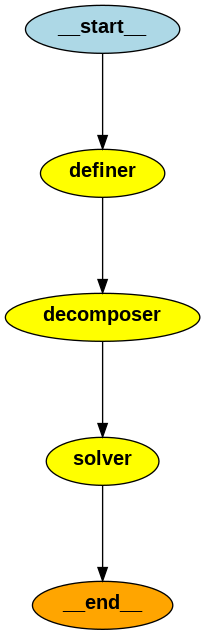

In [13]:
from IPython.display import Image 

Image(graph.get_graph().draw_png())

In [14]:
thread = {"configurable": {"thread_id": 1}}

response = graph.invoke({"query": "What is the solution for x in sin(x)^3 - cos(x) = 4?"}, thread)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<loc

In [15]:
print("\n\n".join(response['solved_steps']))

Excellent! Now that we have the equation sin(x)^3 - cos(x) = 4 in front of us, let's take a closer look at its components. 

As the description says, the equation involves two trigonometric functions: **sine**, represented as sin(x), and **cosine**, represented as cos(x).  

Furthermore, notice that the sine function has a power of 3 (sin(x)^3), making this a **cubic equation** in terms of sin(x). 

Understanding the types of functions and the degree of the equation helps us strategize our approach to finding the solution for 'x'. 


Alright, so we've recognized that we have a somewhat complicated equation: it involves both sine and cosine, and it's cubic in terms of sin(x).  As the next step tells us, there's no magical trigonometric identity that will immediately simplify the equation for us. 

This is actually a common scenario in math! Don't be discouraged by the lack of an obvious simplification. It just means we need to explore other strategies for solving the equation. 

Think o

In [16]:
response['decomposed_steps']

['**Analyze the Equation:** Identify the trigonometric functions involved (sine and cosine) and the degree of the equation (cubic due to sin(x)^3).',
 "**Simplification (if possible):**  Attempt to simplify the equation. In this case, there's no straightforward trigonometric identity to simplify the equation directly.",
 '**Strategic Approach:** Due to the mixed trigonometric functions and the cubic term, consider these potential strategies:',
 '  * **Numerical Methods:** Since a closed-form solution might be complex, explore numerical methods like the Newton-Raphson method or graphical analysis to approximate solutions.',
 '  * **Range Analysis:** Analyze the possible output ranges of sin(x)^3 and -cos(x).  Since each ranges from -1 to 1, their combination cannot exceed 2. This indicates there are NO solutions within the real number domain.',
 '**Solution Presentation:**  If employing numerical methods, clearly state the chosen method and any assumptions made (e.g., initial guess for 